# Test and debug Kalman filter

---

## Equations verified by the simulator

$$
\begin{align}
(1+a) m \frac{d^2z_f}{dt^2} = 
- mg
+ mg \frac{\rho_w}{\rho_f}
- m \frac{c_1}{2L} \Big |\frac{dz_f}{dt} - w \Big | \Big ( \frac{dz_f}{dt} - w \Big )
\end{align}
$$

## Equations employed by the Kalman filter

The Kalman state vector is:

$$
\begin{align*}
\underline{x} &= 
\left(\begin{array}{c} 
x_0\\
x_1\\
x_2\\
x_3
\end{array}\right)
=
\left(\begin{array}{c} 
-dz_f/dt\\
-z_f\\
\gamma_e \\
V_e \\
\end{array}\right)
\end{align*}
$$

Variables estimated by the Kalman filter are therefore the depth temporal rate of evolution ($x_0$, in m/s), depth ($x_1$, in m), equivalent compressibility ($\gamma_e$, in m$^2$) and the equivalent volume ($x_3$,  in m$^3$).

The Kalman filter dynamical equation is:

$$
\begin{align}
d\underline{x}/dt &= 
\left(\begin{array}{c} 
dx_0/dt\\
dx_1/dt\\
dx_2/dt\\
dx_3/dt
\end{array}\right)
=
\left(\begin{array}{c} 
-d^2z_f/dt^2\\
-dz_f/dt\\
0\\
0
\end{array}\right)
= 
\left(\begin{array}{c} 
-A (x_3 - x_2 x_1 +v) - B |x_0| x_0 \\
x_0\\
0 \\
0
\end{array}\right), \label{eq:dxdt}
\end{align}
$$

, where several parameters have been introduced: $A = g\rho/2m$ and $B = c_1/4L$.


which dimensionally is equivalent to:

\begin{align}
(1+a) m \frac{d^2z_f}{dt^2} = 
g \rho (V_e + \gamma_e z + v)
- m \frac{c_1}{2L} \Big |\frac{dz_f}{dt} \Big | \Big ( \frac{dz_f}{dt} \Big )
\end{align}

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import interp1d
from copy import deepcopy

import cognac.float as fl

In [2]:
# select a water profile
#w = fl.waterp(lon=-50.,lat=40.) # Gulf Stream
w = fl.waterp(lon=6.,lat=40.) # Mediterranean sea
#print(w)

--- 
## Instantiate the float object

In [3]:
# Init now active control of the vertical position

#
z=np.arange(-350.,0.,1.)
rho_w, p, temp = w.get_rho(z), w.get_p(z), w.get_temp(z)

#
f = fl.autonomous_float(model='ENSTA')

# adjust mass to be at equilibrium at -25m
iz = np.argmin(np.abs(z+25))
f.adjust_m(p[iz],temp[iz],rho_w[iz])

# set vmax such that the float has an extra buoyancy at the surface equal
# to a cylinder ot 2cm radius and height of 10cm (antenna casing)
iz = np.argmin(np.abs(z+0.))
vmax = f.volume4equilibrium(p[iz],temp[iz],rho_w[iz]) + .1*np.pi*.02**2
# use d_max to prescribe piston max course
dmax = .07

#
f.init_piston(d_max=dmax, vol_max=vmax, vol=vmax)
print(f)

# compute bounds on motions
fmax, fmin, afmax, wmax = f.compute_bounds(w,-50.)

-3248.9 g  were added to the float in order to be at equilibrium at 25 dbar 

Piston vol_min reset from d_min, d_max and vol_max
Float parameters: 
  L     = 0.50 m      - float length
  r     = 0.06 m      - float radius
  m     = 5.80 kg     - float mass
  V     = 5.65e+03 cm^3   - float volume
  rho_cte = m/V = 1.02e+09 kg.cm^3   - float baseline density
  gamma = 9.30e-05 /dbar  - mechanical compressibility
  alpha = 0.00e+00 /degC  - thermal compressibility
  temp0 = 0.00e+00  degC  - reference temperature
  a = 1.00e+00  (no dimension)  - float added mass
  c0 = 0.00e+00  (no dimension)  - float drag parameter 0
  c1 = 1.00e+00  (no dimension)  - float drag parameter 1
Piston parameters and state: 
  r     = 2.50 cm        - piston radius
  d     = 0.00 cm        - present piston displacement
  vol   = 115.47 cm^3      - present volume addition
  d_increment  = 3.65e-02 mm        - smallest variation of translation motion for the piston
  vol_increment  = 7.16e-02 cm^3        - s

In [4]:
# adjust piston to be at equilibrium -1m
z0 = -1.
iz = np.argmin(np.abs(z-z0))
vstart = f.set_piston4equilibrium(p[iz],temp[iz],rho_w[iz])
print('z equilibrium = %.1fm' %(f.z4equilibrium(w) ) ) # check

Piston reset for equilibrium : vol=-1.0e+01 cm^3  
z equilibrium = -1.0m


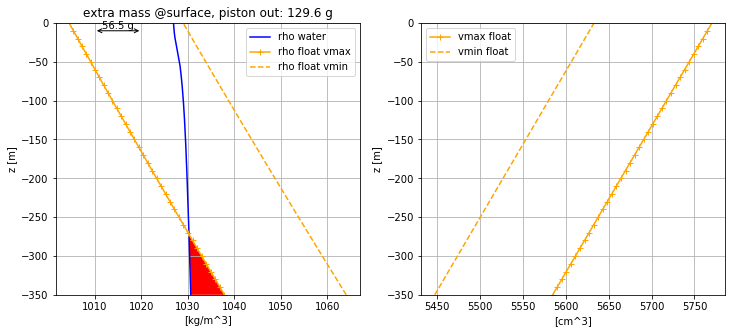

In [5]:
# show densities
fig, ax = plt.subplots(1, 2, figsize=(12,5))
fl.plot_float_density(z, f, w, ax=ax[0])
fl.plot_float_volume(z, f, w, ax=ax[1])

In [6]:
delta_rho = 2 # [kg/m3] change of water density over the depth of interest 
L_rho = 100 # [m] characteristic length scale for water density changes
V_e_rho = f.V*delta_rho/f.rho_cte # back of the envelope estimate for V_e
acceleration_rho = 0.5*fl.g*delta_rho/f.rho_cte

### equivalent volume and compressibilities

The float dynamics may be simplified and expressed as:

\begin{align}
2m\frac{d^2z_f}{dt^2}
+ m\frac{c_1}{2L} \Big |\frac{dz_f}{dt} \Big | \frac{dz_f}{dt} = 
g \rho (V_e + \gamma_e z + v),
\label{eq:zf_reg3}
\end{align}

where $V_e= V_0 [\delta\rho_w(\overline{z}) - \overline{z} \partial_z \rho_w ]/\rho$, $\gamma_e = V_0 \partial_z \rho_w /\rho + \gamma_V$, and, $\overline{z}$ is the averaged vertical level the float is moving around.


Back of the envelope estimate of V_e: 1.1e+01 cm^3


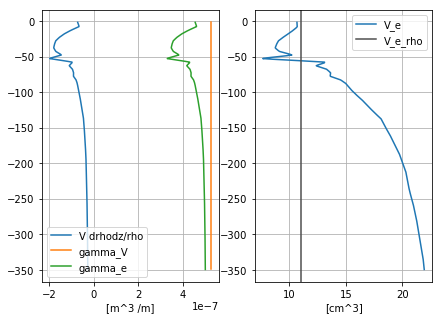

In [7]:
zm = (z[1:]+z[:-1])*.5

V_e = f.V*( (rho_w[:-1]+rho_w[1:])*.5 - f.rho_cte 
           - zm*np.diff(rho_w)/np.diff(z)
          )/f.rho_cte

gamma_V = f.V*f.gamma
gamma_rho = f.V*np.diff(rho_w)/f.rho_cte/np.diff(z)

gamma_e = gamma_rho + gamma_V

V_e25 = interp1d(zm, V_e, kind='linear')(-25)
gamma_e25 = interp1d(zm, gamma_e, kind='linear')(-25)

plt.figure(figsize=(7,5))
ax=plt.subplot(121)
ax.plot(gamma_rho, zm, label='V drhodz/rho')
ax.plot(gamma_V+0.*zm, zm, label='gamma_V')
ax.plot(gamma_e, zm, label='gamma_e')
ax.grid()
ax.legend(loc=3)
ax.set_xlabel('[m^3 /m]')


ax=plt.subplot(122)
ax.plot(V_e*1e6, zm, label='V_e')
ax.axvline(x=V_e_rho*1e6, color='0.3',label='V_e_rho')
ax.grid()
ax.legend()
ax.set_xlabel('[cm^3]')

print('Back of the envelope estimate of V_e: %.1e cm^3' %(V_e_rho*1e6))

---

### set up desired trajectory

In [8]:
# we start by constructing a trajectory that can be followed by the float
target_velocity = 0.05
z_target = fl.descent(3600, -25., wmax=target_velocity, zstart=z0)

In [9]:
f0 = deepcopy(f)

---

### regulation

In [10]:
# use PID for control to decouple Kalman filtering from control
tau = 15. # time scale
u = f.piston.u_max/4.

_c = {'mode': 'pid', 'dt': 2.,
      'Kp': u, 'Ki': u/tau*1., 'Kd': u*tau*5., 
      'dz_nochattering': 0.}

---

### Kalman filter with exact dynamical system

The true dynamical equation is reset to that used by the Kalman and regulation:

\begin{align}
(1+a) m \frac{d^2z_f}{dt^2} = 
g \rho (V_e + \gamma_e z + v)
- m \frac{c_1}{2L} \Big |\frac{dz_f}{dt} \Big | \Big ( \frac{dz_f}{dt} \Big )
\end{align}

In [11]:
V_e_cst = 1e-5
gamma_e_cst = 0.5*f.gammaV

def _compute_force(z, w, waterp, Lv, v=None, sum=False):
    g = 9.81
    f_b = g * f.rho_cte * (V_e_cst + gamma_e_cst * z + v)
    f_d = - f.m * f.c1/2/Lv * np.abs(w) * w
    if sum:
        return f_b+f_d
    else:
        return f_b+f_d, f_b, f_d
    
f.compute_force = _compute_force    

Kalman filter: 
  dt     = 0.20 s     - filter time step
  x_hat   = [-0.00e+00,1.00e+00,5.26e-07,0.00e+00] - kalman state 
  sqrt(diag(gamma)): [5.00e-02 1.00e-02 5.26e-07 1.00e-05]
  sqrt(gamma_alpha) / dt: [9.57e-03 1.91e-03 1.46e-10 2.78e-09]
  sqrt(gamma_beta): [1.00e-02]
Control parameters: 
  mode = pid 
  dt = 2.00e+00 
  dz_nochattering = 0.00e+00 
  Kp = 1.07e-06 
  Ki = 7.16e-08 
  Kd = 8.05e-05 
  continuous = 1.00e+00 

Start time stepping for 11 min ...
... time stepping done
Extrapolated energy conssumption: 7.9e-02 Wh/day = 2.4 Wh/30day


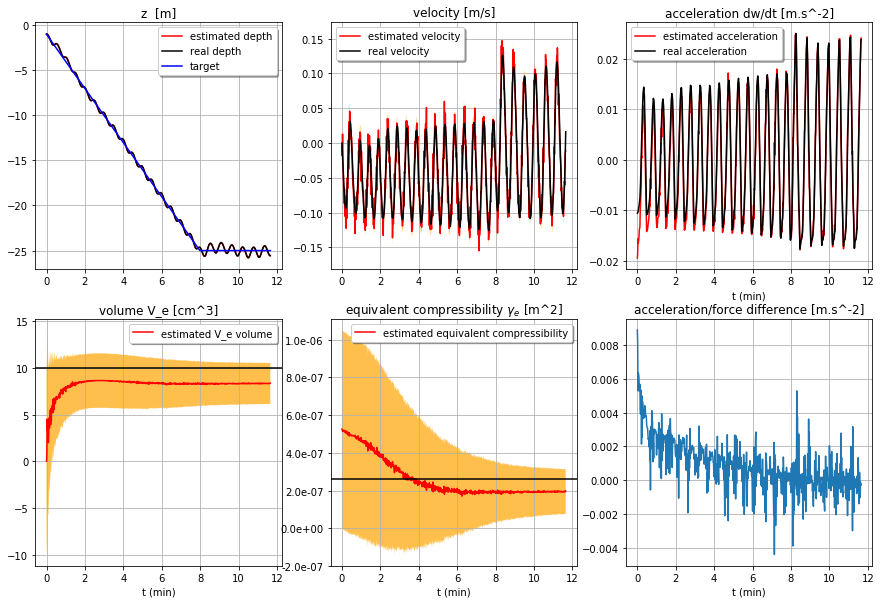

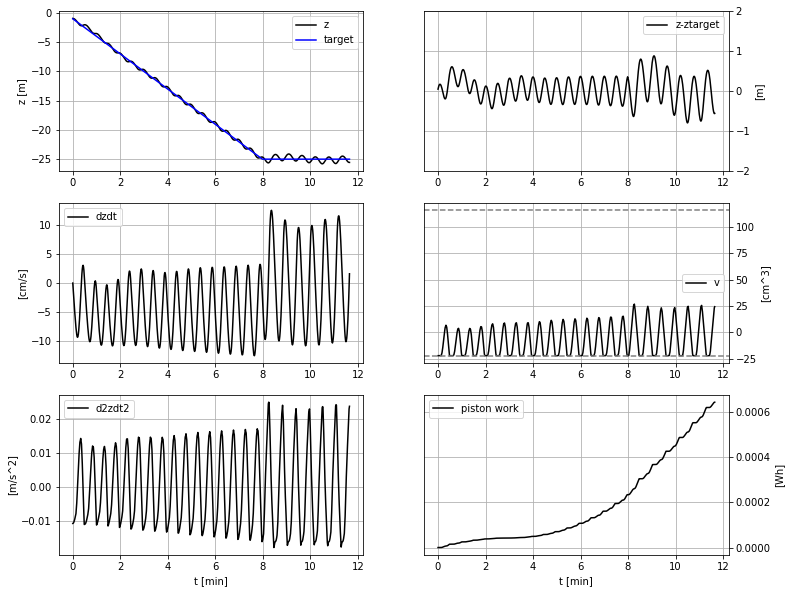

In [12]:
#expected_velocity = 0.1
#expected_acceleration = expected_velocity/tau*1e1 # value diagnosed a posteriori
expected_tau_Vgamma = 3600 # time scale used to scale V_e and gamma_e time rate of change

# general kalman filter parameters
_k = {'dt':.2, 'depth_error': 1e-2}
# initial state covariance:
_k.update({'gamma':np.array([_k['depth_error']/_k['dt'],
                             _k['depth_error'],
                             f.gammaV,
                             V_e_cst,
                            ])**2})
# dynamics covariance:
_k.update({'gamma_alpha_scaled': np.array([acceleration_rho,
                                           acceleration_rho*_k['dt'],
                                           f.gammaV/expected_tau_Vgamma,
                                           V_e_cst/expected_tau_Vgamma,
                                          ])**2 *1e0})

Tsim = 700.
f.time_step(w,T=Tsim, dt_step=.1, dt_log=1., z=z0, w=0., v=f.piston.vol_min,
            piston=True, z_target=z_target, ctrl=_c, kalman=_k, verbose=0)
fl.plot_kalman(f.log, f, V_e = V_e_cst, gamma_e = gamma_e_cst, z_target=z_target)
f.plot_logs(z_target=z_target)

In the simulation above:

- dynamical errors are small (10% of acceleration)
 
- errors on $V_e$ and $\gamma_e$ grow with larger depth error and initial errors

- when intial errors are small (say 1% of what we think are good values), convergence is slow

We illustrate next what happens if the depth error is reduced


Kalman filter: 
  dt     = 0.20 s     - filter time step
  x_hat   = [-0.00e+00,1.00e+00,5.26e-07,0.00e+00] - kalman state 
  sqrt(diag(gamma)): [5.00e-03 1.00e-03 5.26e-07 1.00e-05]
  sqrt(gamma_alpha) / dt: [9.57e-03 1.91e-03 1.46e-10 2.78e-09]
  sqrt(gamma_beta): [1.00e-03]
Control parameters: 
  mode = pid 
  dt = 2.00e+00 
  dz_nochattering = 0.00e+00 
  Kp = 1.07e-06 
  Ki = 7.16e-08 
  Kd = 8.05e-05 
  continuous = 1.00e+00 

Start time stepping for 11 min ...
... time stepping done


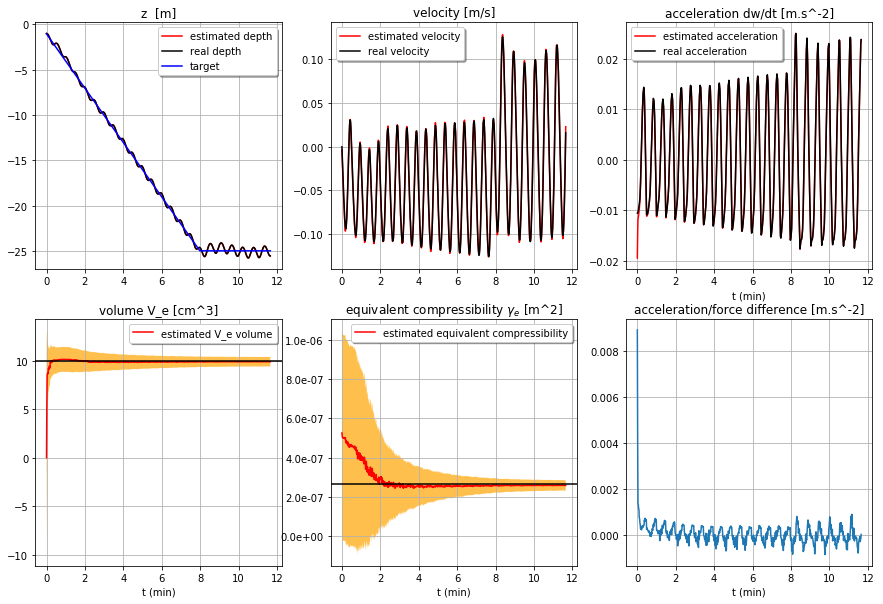

In [13]:
# reduces the depth error:
_k['depth_error'] = 1e-3
# update the initial covariance
_k.update({'gamma':np.array([_k['depth_error']/_k['dt'],
                             _k['depth_error'],
                             f.gammaV,
                             V_e_cst,
                            ])**2})
#
f.time_step(w,T=Tsim, dt_step=.1, dt_log=1., z=z0, w=0., v=f.piston.vol_min,
            piston=True, z_target=z_target, ctrl=_c, kalman=_k, verbose=0)
fl.plot_kalman(f.log, f, V_e = V_e_cst, gamma_e = gamma_e_cst, z_target=z_target)

We increase the Kalman filter time step next by a factor 2.5. Remember the kalman filter time step needs to be smaller than the regulation time step.

Covariances are reduced.

Kalman filter: 
  dt     = 0.50 s     - filter time step
  x_hat   = [-0.00e+00,1.00e+00,5.26e-07,0.00e+00] - kalman state 
  sqrt(diag(gamma)): [2.00e-02 1.00e-02 5.26e-07 1.00e-05]
  sqrt(gamma_alpha) / dt: [9.57e-03 4.79e-03 1.46e-10 2.78e-09]
  sqrt(gamma_beta): [1.00e-02]
Control parameters: 
  mode = pid 
  dt = 2.00e+00 
  dz_nochattering = 0.00e+00 
  Kp = 1.07e-06 
  Ki = 7.16e-08 
  Kd = 8.05e-05 
  continuous = 1.00e+00 

Start time stepping for 11 min ...
... time stepping done


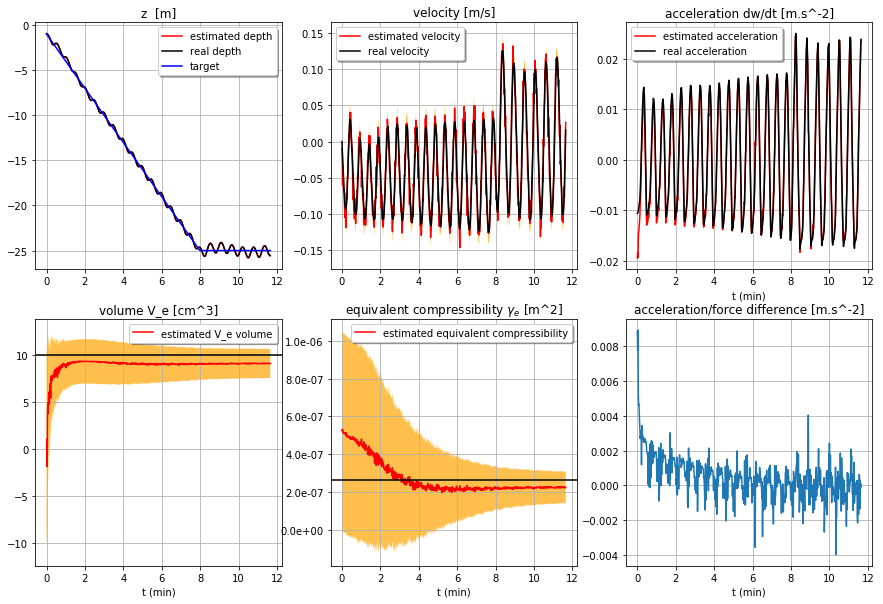

In [14]:
_k['dt'] = .5
_k['depth_error'] = 1e-2
# update covariances
_k.update({'gamma':np.array([_k['depth_error']/_k['dt'],
                             _k['depth_error'],
                             f.gammaV,
                             V_e_cst,
                            ])**2,
           'gamma_alpha_scaled': np.array([acceleration_rho,
                                           acceleration_rho*_k['dt'],
                                           f.gammaV/expected_tau_Vgamma,
                                           V_e_cst/expected_tau_Vgamma,
                                          ])**2 *1e0})
#
f.time_step(w,T=Tsim, dt_step=.1, dt_log=1., z=z0, w=0., v=f.piston.vol_min,
            piston=True, z_target=z_target, ctrl=_c, kalman=_k, verbose=0)
fl.plot_kalman(f.log, f, V_e = V_e_cst, gamma_e = gamma_e_cst, z_target=z_target)

Next we reduce the depth error in the noise but not in the observation covariance

This does not seem to affect the quality of estimates except for a reduction of the noise.

Kalman filter: 
  dt     = 0.20 s     - filter time step
  x_hat   = [-0.00e+00,1.00e+00,5.26e-07,0.00e+00] - kalman state 
  sqrt(diag(gamma)): [5.00e-02 1.00e-02 5.26e-07 1.00e-05]
  sqrt(gamma_alpha) / dt: [9.57e-03 1.91e-03 1.46e-10 2.78e-09]
  sqrt(gamma_beta): [1.00e-02]
Control parameters: 
  mode = pid 
  dt = 2.00e+00 
  dz_nochattering = 0.00e+00 
  Kp = 1.07e-06 
  Ki = 7.16e-08 
  Kd = 8.05e-05 
  continuous = 1.00e+00 

Start time stepping for 11 min ...
... time stepping done


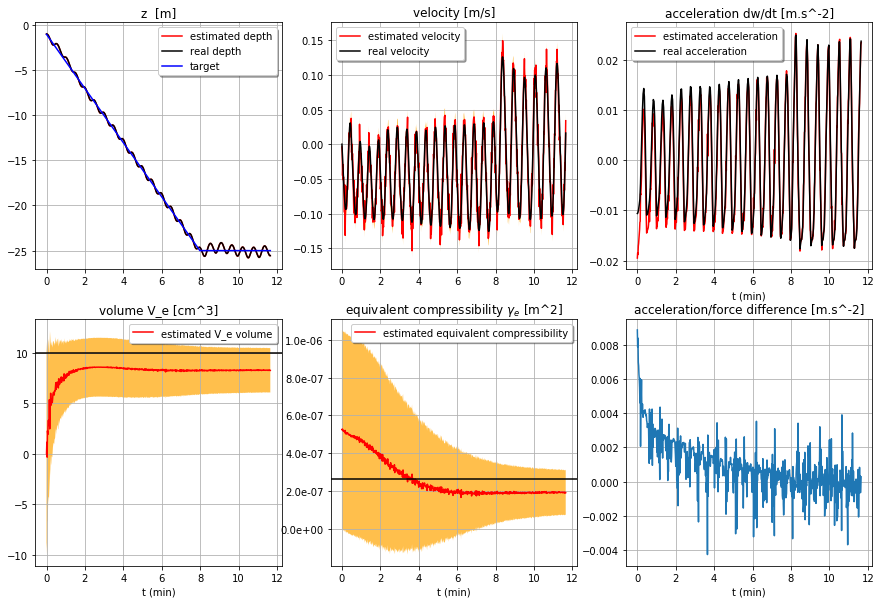

In [15]:
_k = {'dt':.2, 'depth_error': 1e-2}
depth_error_cov = 1e-2
# covariances
_k.update({'gamma':np.array([_k['depth_error']/_k['dt'],
                             _k['depth_error'],
                             f.gammaV,
                             V_e_cst,
                            ])**2,
          'gamma_alpha_scaled': np.array([acceleration_rho,
                                           acceleration_rho*_k['dt'],
                                           f.gammaV/expected_tau_Vgamma,
                                           V_e_cst/expected_tau_Vgamma,
                                          ])**2 *1e0,
          'gamma_beta': np.diag([depth_error_cov**2])
          })
#
f.time_step(w,T=Tsim, dt_step=.1, dt_log=1., z=z0, w=0., v=f.piston.vol_min,
            piston=True, z_target=z_target, ctrl=_c, kalman=_k, verbose=0)
fl.plot_kalman(f.log, f, V_e = V_e_cst, gamma_e = gamma_e_cst, z_target=z_target)

---

### Kalman filter with real physics and PID

In [36]:
f = deepcopy(f0)

Kalman filter: 
  dt     = 0.50 s     - filter time step
  x_hat   = [-0.00e+00,1.00e+00,5.26e-07,0.00e+00] - kalman state 
  sqrt(diag(gamma)): [2.00e-02 1.00e-02 5.26e-07 1.10e-05]
  sqrt(gamma_alpha) / dt: [9.57e-03 4.79e-03 5.52e-11 5.52e-09]
  sqrt(gamma_beta): [1.00e-02]
Control parameters: 
  mode = kalman_feedback2 
  dt = 2.00e+00 
  dz_nochattering = 0.00e+00 
  tau = 5.00e+00 
  nu = 6.37e-02 
  delta = 1.00e-01 
  continuous = 1.00e+00 

Start time stepping for 11 min ...
... time stepping done


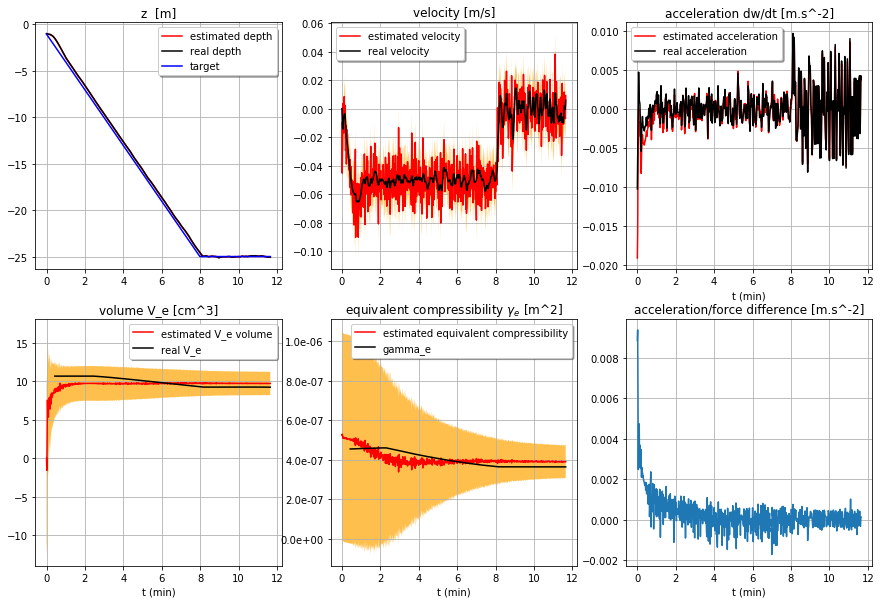

In [37]:
_k = {'dt':.5, 'depth_error': 1e-2}

_k.update({'gamma':np.array([_k['depth_error']/_k['dt'],
                             _k['depth_error'],
                             f.gammaV,
                             f.V*delta_rho/f.rho_cte,
                            ])**2,
           'gamma_alpha_scaled': np.array([acceleration_rho,
                                           acceleration_rho*_k['dt'],
                                           target_velocity*V_e_rho/L_rho**2,
                                           target_velocity*V_e_rho/L_rho,
                                           ])**2 *1e0})

f.time_step(w,T=Tsim, dt_step=.1, dt_log=1., z=z0, w=0., v=f.piston.vol_min,
            piston=True, z_target=z_target, ctrl=_c, kalman=_k, verbose=0)

#fl.plot_kalman(f.log, f, V_e = V_e25, gamma_e = gamma_e25)
#
V_e_z = interp1d(zm, V_e, kind='linear', bounds_error=False)(f.log['state']['z'].values)
gamma_e_z = interp1d(zm, gamma_e, kind='linear', bounds_error=False)(f.log['state']['z'].values)
fl.plot_kalman(f.log, f, V_e = V_e_z, gamma_e = gamma_e_z, z_target=z_target)

In [38]:
print('acceleration_rho = %.1e m/s^2' %acceleration_rho)

acceleration_rho = 9.6e-03 m/s^2


The anticipated errors on acceleration (`acceleration_rho`) where about 0.01. They turned out to be of that order initialy but decreased down to 0.002 eventually (bottom-right figure).

Velocity error estimates decrease fairly rapidly to reach values around 2.1 cm/s: why this value?
The Kalman filter time step appears to have an impact on this value.

0    0.022268
1    0.025153
2    0.025655
3    0.025320
4    0.024763
Name: gamma_diag0, dtype: float64


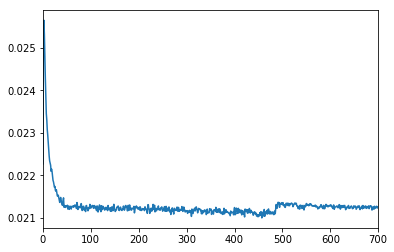

In [39]:
print(np.sqrt(f.log['kalman']._df['gamma_diag0']).head())
np.sqrt(f.log['kalman']._df['gamma_diag0']).plot()

---

### Kalman filter with feedback regulation

We start with a feedback with the true state. Note that physics is still the approximated one in the regulation though.

Decreasing `tau` (less than 10s, we used 15s initially) leads to an improved match up with the target trajectory.
A value of 1 second leads to spurious oscillations when we want the float to stay at a constant depth though.

Kalman filter: 
  dt     = 0.50 s     - filter time step
  x_hat   = [-0.00e+00,1.00e+00,5.26e-07,0.00e+00] - kalman state 
  sqrt(diag(gamma)): [2.00e-02 1.00e-02 5.26e-07 1.10e-05]
  sqrt(gamma_alpha) / dt: [9.57e-03 4.79e-03 5.52e-11 5.52e-09]
  sqrt(gamma_beta): [1.00e-02]
Control parameters: 
  mode = feedback2 
  dt = 2.00e+00 
  dz_nochattering = 0.00e+00 
  tau = 5.00e+00 
  nu = 6.37e-02 
  delta = 1.00e-01 
  continuous = 1.00e+00 

Start time stepping for 11 min ...
... time stepping done


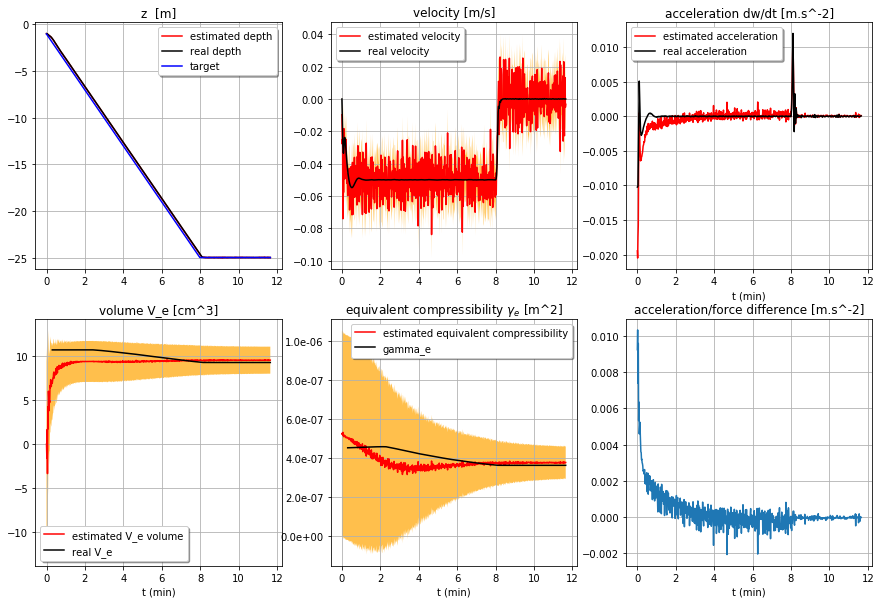

In [40]:
 _c = {'mode': 'feedback2', 'dt': 2., 'dz_nochattering': 0.,
      'nu': 2.*target_velocity*2./np.pi, 'tau': 5., 'delta': .1, 
     }

f.time_step(w,T=Tsim, dt_step=.1, dt_log=1., z=z0, w=0., v=f.piston.vol_min,
            piston=True, z_target=z_target, ctrl=_c, kalman=_k, verbose=0)

#fl.plot_kalman(f.log, f, V_e = V_e25, gamma_e = gamma_e25)
#
V_e_z = interp1d(zm, V_e, kind='linear', bounds_error=False)(f.log['state']['z'].values)
gamma_e_z = interp1d(zm, gamma_e, kind='linear', bounds_error=False)(f.log['state']['z'].values)
fl.plot_kalman(f.log, f, V_e = V_e_z, gamma_e = gamma_e_z, z_target=z_target)

Extrapolated energy conssumption: 3.6e-03 Wh/day = 0.1 Wh/30day


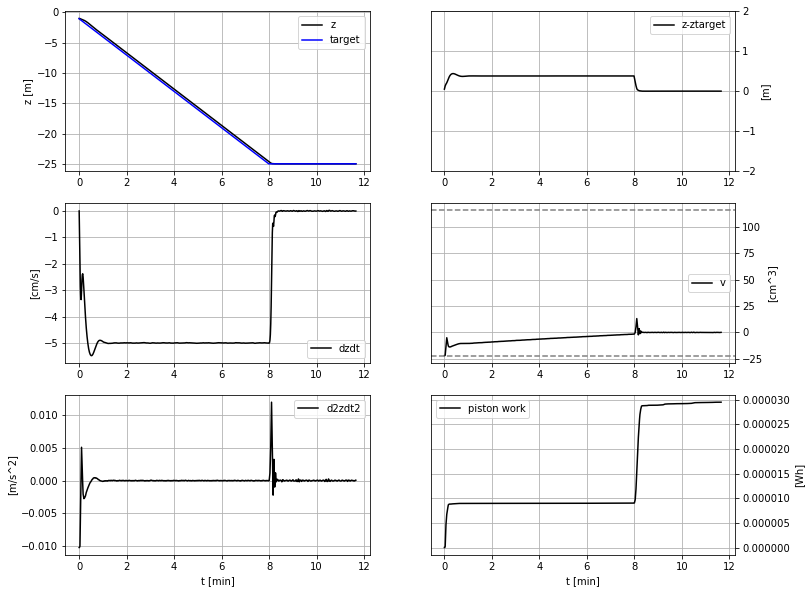

In [41]:
f.plot_logs(z_target=z_target)

In [42]:
f.log['dynamics'].plot_bk()

Loading BokehJS ...

Overestimates of gamma_e (gammaV is used here) may explain the inability of the float to stick to the descent track. See u4 importance on the plot below

We use now the kalman filter estimate for the regulation instead of the true state

Kalman filter: 
  dt     = 0.50 s     - filter time step
  x_hat   = [-0.00e+00,1.00e+00,5.26e-07,0.00e+00] - kalman state 
  sqrt(diag(gamma)): [2.00e-02 1.00e-02 5.26e-07 1.10e-05]
  sqrt(gamma_alpha) / dt: [9.57e-03 4.79e-03 5.52e-11 5.52e-09]
  sqrt(gamma_beta): [1.00e-02]
Control parameters: 
  mode = kalman_feedback2 
  dt = 2.00e+00 
  dz_nochattering = 0.00e+00 
  tau = 5.00e+00 
  nu = 6.37e-02 
  delta = 1.00e-01 
  continuous = 1.00e+00 

Start time stepping for 11 min ...
... time stepping done


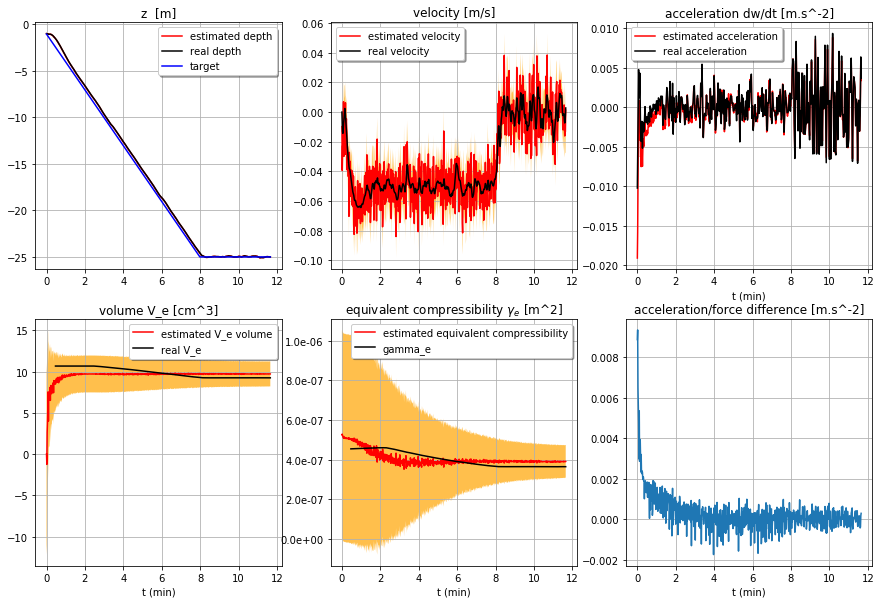

In [43]:
# feedback with kalman estimated state
_c = {'mode': 'kalman_feedback2', 'dt': 2., 'dz_nochattering': 0.,
      'nu': 2.*target_velocity*2./np.pi, 'tau': 5., 'delta': .1, 
     }

f.time_step(w,T=Tsim, dt_step=.1, dt_log=1., z=z0, w=0., v=f.piston.vol_min,
            piston=True, z_target=z_target, ctrl=_c, kalman=_k, verbose=0)

V_e_z = interp1d(zm, V_e, kind='linear', bounds_error=False)(f.log['state']['z'].values)
gamma_e_z = interp1d(zm, gamma_e, kind='linear', bounds_error=False)(f.log['state']['z'].values)
fl.plot_kalman(f.log, f, V_e = V_e_z, gamma_e = gamma_e_z, z_target=z_target)

Extrapolated energy conssumption: 7.2e-02 Wh/day = 2.2 Wh/30day


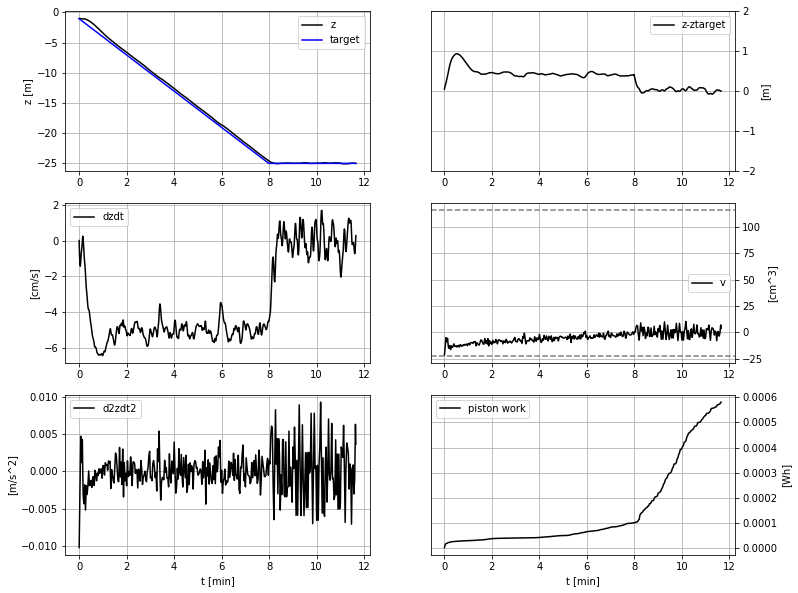

In [44]:
f.plot_logs(z_target=z_target)

In [45]:
f.log['dynamics'].plot_bk()

Loading BokehJS ...

### with reduced error on depth

Kalman filter: 
  dt     = 0.50 s     - filter time step
  x_hat   = [-0.00e+00,1.00e+00,5.26e-07,0.00e+00] - kalman state 
  sqrt(diag(gamma)): [2.00e-03 1.00e-03 5.26e-07 1.10e-05]
  sqrt(gamma_alpha) / dt: [9.57e-03 4.79e-03 5.52e-11 5.52e-09]
  sqrt(gamma_beta): [1.00e-03]
Control parameters: 
  mode = kalman_feedback2 
  dt = 2.00e+00 
  dz_nochattering = 0.00e+00 
  tau = 5.00e+00 
  nu = 6.37e-02 
  delta = 1.00e-01 
  continuous = 1.00e+00 

Start time stepping for 11 min ...
... time stepping done


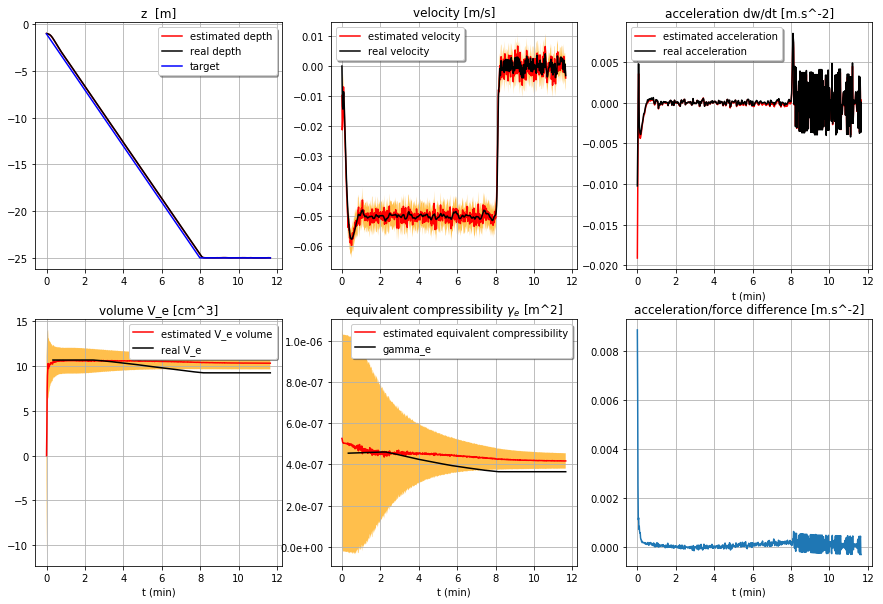

In [48]:
_k = {'dt':.5, 'depth_error': 1e-3}

_k.update({'gamma':np.array([_k['depth_error']/_k['dt'],
                             _k['depth_error'],
                             f.gammaV,
                             f.V*delta_rho/f.rho_cte,
                            ])**2,
           'gamma_alpha_scaled': np.array([acceleration_rho,
                                           acceleration_rho*_k['dt'],
                                           target_velocity*V_e_rho/L_rho**2,
                                           target_velocity*V_e_rho/L_rho,
                                           ])**2})

f.time_step(w,T=Tsim, dt_step=.1, dt_log=1., z=z0, w=0., v=f.piston.vol_min,
            piston=True, z_target=z_target, ctrl=_c, kalman=_k, verbose=0)

V_e_z = interp1d(zm, V_e, kind='linear', bounds_error=False)(f.log['state']['z'].values)
gamma_e_z = interp1d(zm, gamma_e, kind='linear', bounds_error=False)(f.log['state']['z'].values)
fl.plot_kalman(f.log, f, V_e = V_e_z, gamma_e = gamma_e_z, z_target=z_target)

Extrapolated energy conssumption: 4.4e-02 Wh/day = 1.3 Wh/30day


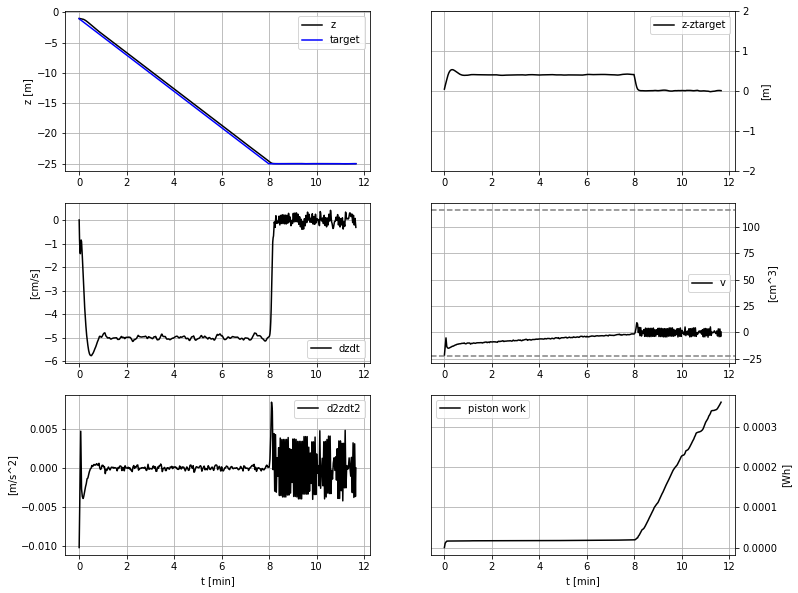

In [49]:
f.plot_logs(z_target=z_target)